In [1]:
import os
import sys
import re
import time
import yaml
import shutil
import argparse
import tarfile
import tempfile
import random
import subprocess
import copy

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F

import boda
from boda.common import utils, constants
from boda.common.utils import unpack_artifact, model_fn

import hypertune

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
'''
python /home/ubuntu/boda2/src/generate.py 
--params_module StraightThroughParameters 
  --batch_size 512 --n_channels 4 --length 200 --n_samples 10 
--energy_module OverMaxEnergy 
  --model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz 
  --bias_cell 0 --bending_factor 1.0 --a_min -2.0 --a_max 6.0 
--generator_module FastSeqProp 
  --energy_threshold -2.0 --max_attempts 20 --n_steps 200 
--penalty_module StremePenalty 
  --score_pct 0.0 --n_proposals 2000 500 500 500 500 500 
--proposal_path gs://syrgoth/boda_library_design_202112/sg__k562__fsp__track_001_round_5 
'''

'\npython /home/ubuntu/boda2/src/generate.py \n--params_module StraightThroughParameters \n  --batch_size 512 --n_channels 4 --length 200 --n_samples 10 \n--energy_module OverMaxEnergy \n  --model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz \n  --bias_cell 0 --bending_factor 1.0 --a_min -2.0 --a_max 6.0 \n--generator_module FastSeqProp \n  --energy_threshold -2.0 --max_attempts 20 --n_steps 200 \n--penalty_module StremePenalty \n  --score_pct 0.0 --n_proposals 2000 500 500 500 500 500 \n--proposal_path gs://syrgoth/boda_library_design_202112/sg__k562__fsp__track_001_round_5 \n'

In [3]:
A_col = (12, 128, 64)
C_col = (56, 83, 164)
G_col = (251, 177, 22)
T_col = (237, 31, 36)
nt_col = np.array([A_col, C_col, G_col, T_col])

In [4]:
logits = torch.randn(512,
                     4,
                     200)

left_flank = utils.dna2tensor( 
    constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0).expand(logits.shape[0], -1, -1)

right_flank= utils.dna2tensor( 
    constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0).expand(logits.shape[0], -1, -1)


In [5]:
with tempfile.TemporaryDirectory() as tmpdirname:
    unpack_artifact('gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz', tmpdirname)
    model = model_fn(os.path.join(tmpdirname,'artifacts'))
model.cuda()
model.eval()


Copying gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz...
/ [1 files][ 49.3 MiB/ 49.3 MiB]                                                
Operation completed over 1 objects/49.3 MiB.                                     
archive unpacked in /tmp/tmp7_dd_qob


Loaded model from 20211113_021200 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

# Fast SeqProp

In [6]:
Params = boda.generator.StraightThroughParameters(
    data=logits, left_flank=left_flank, right_flank=right_flank, 
    n_samples=10, use_affine=False
)
Energy = boda.generator.energy.OverMaxEnergy(
    model=model,
    bias_cell=0, bending_factor=1.0, a_min=-2.0, a_max=6.0
)
FSP = boda.generator.FastSeqProp(Energy, Params)

Steps: 100%|█████████████| 200/200 [01:10<00:00,  2.83it/s, Loss=-7.82, LR=1e-6]


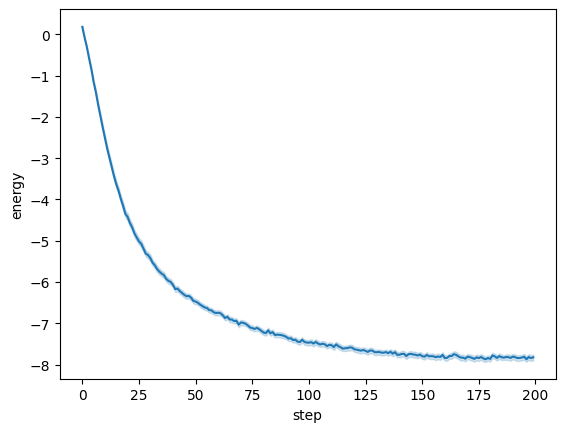

In [7]:
FSP.run(n_steps=200, lr_scheduler=True, create_plot=True, log_param_hist=True)

337


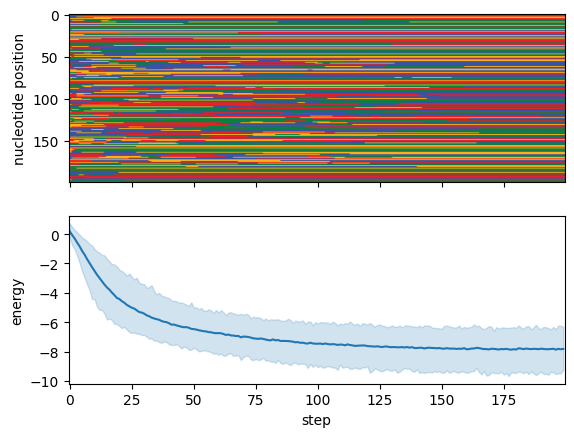

In [8]:
fig, ax = plt.subplots(2,1,sharex=True)

seq_idx = np.random.choice(np.arange(512))
print(seq_idx)
ax[0].imshow(
    np.concatenate(
        [
            nt_col[F.softmax(torch.tensor(FSP.param_hist[:,seq_idx,:,:]),dim=1).max(dim=1).indices]/255.,
            #F.softmax(torch.tensor(FSP.param_hist[:,seq_idx,:,:]),dim=1).max(dim=1).values[:,:,np.newaxis]
        ],
        axis=-1
    ).transpose(1,0,2)
    
)
ax[0].set_aspect('auto')
ax[0].set_ylabel('nucleotide position')

sns.lineplot(
    data=pd.DataFrame(
    {'energy': FSP.energy_hist.flatten(),
    'step': np.repeat(np.arange(200), 512)}
    ), 
    x='step',
    y='energy',
    errorbar="pi",
    ax=ax[1]
)


plt.show()

# Simulated annealing

In [9]:
logits = torch.randn(2048,
                     4,
                     200)

left_flank = utils.dna2tensor( 
    constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0).expand(logits.shape[0], -1, -1)

right_flank= utils.dna2tensor( 
    constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0).expand(logits.shape[0], -1, -1)


In [10]:
Params = boda.generator.BasicParameters(
    data=logits, left_flank=left_flank, right_flank=right_flank
).cuda()

Energy = boda.generator.energy.OverMaxEnergy(
    model=model,
    bias_cell=0, bending_factor=0.0, a_min=-2.0, a_max=6.0
)

SA = boda.generator.SimulatedAnnealing(Params, Energy, n_positions=3, gamma=0.501)

In [11]:
samples = SA.collect_samples(n_steps=2000, n_burnin=0)

collect samples
100%|███████████████████████████████████████| 2000/2000 [02:34<00:00, 12.91it/s]


In [12]:
samples['samples']['states'].shape

torch.Size([2000, 2048, 4, 200])

In [13]:
samples['samples']['energies'].shape

torch.Size([2000, 2048])

1239


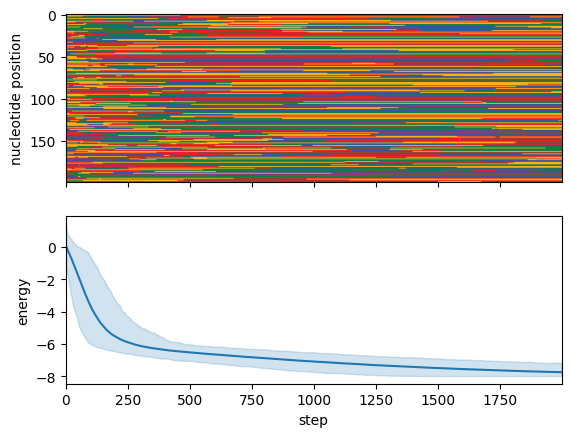

In [14]:
fig, ax = plt.subplots(2,1,sharex=True)

seq_idx = np.random.choice(np.arange(2048))
print(seq_idx)
ax[0].imshow(
    np.concatenate(
        [
            nt_col[samples['samples']['states'][:,seq_idx,:,:].max(dim=1).indices]/255.,
            #F.softmax(torch.tensor(FSP.param_hist[:,seq_idx,:,:]),dim=1).max(dim=1).values[:,:,np.newaxis]
        ],
        axis=-1
    ).transpose(1,0,2)
    
)
ax[0].set_aspect('auto')
ax[0].set_ylabel('nucleotide position')

sns.lineplot(
    data=pd.DataFrame(
    {'energy': samples['samples']['energies'].flatten(),
    'step': np.repeat(np.arange(2000), 2048)}
    ), 
    x='step',
    y='energy',
    errorbar="pi",
    ax=ax[1]
)


plt.show()

# Agg plot

168
485


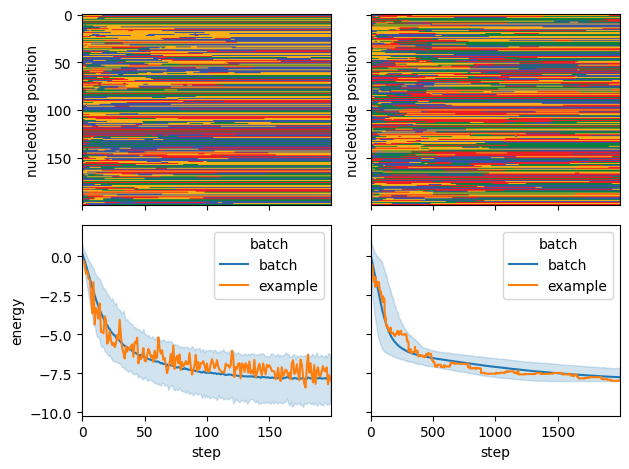

In [15]:
fig, ax = plt.subplots(2,2,sharex='col',sharey='row')

seq_idx = np.random.choice(np.arange(512))
print(seq_idx)
ax[0,0].imshow(
    np.concatenate(
        [
            nt_col[F.softmax(torch.tensor(FSP.param_hist[:,seq_idx,:,:]),dim=1).max(dim=1).indices]/255.,
            #F.softmax(torch.tensor(FSP.param_hist[:,seq_idx,:,:]),dim=1).max(dim=1).values[:,:,np.newaxis]
        ],
        axis=-1
    ).transpose(1,0,2)
    
)
ax[0,0].set_aspect('auto')
ax[0,0].set_ylabel('nucleotide position')

e_data = pd.DataFrame(
    {'energy': FSP.energy_hist.flatten(),
    'step': np.repeat(np.arange(200), 512),
    'batch':'batch'}
)

e_data = pd.concat( [e_data, pd.DataFrame(
    {'energy': FSP.energy_hist[:,seq_idx],
    'step': np.arange(200),
    'batch':'example'}
)])

sns.lineplot(
    data=e_data, 
    x='step',
    y='energy',
    hue='batch',
    errorbar="pi",
    ax=ax[1,0]
)


seq_idx = np.random.choice(np.arange(2048))
print(seq_idx)
ax[0,1].imshow(
    np.concatenate(
        [
            nt_col[samples['samples']['states'][:,seq_idx,:,:].max(dim=1).indices]/255.,
            #F.softmax(torch.tensor(FSP.param_hist[:,seq_idx,:,:]),dim=1).max(dim=1).values[:,:,np.newaxis]
        ],
        axis=-1
    ).transpose(1,0,2)
    
)
ax[0,1].set_aspect('auto')
ax[0,1].set_ylabel('nucleotide position')

e_data = pd.DataFrame(
    {'energy': samples['samples']['energies'].flatten(),
    'step': np.repeat(np.arange(2000), 2048),
    'batch':'batch'}
)

e_data = pd.concat( [e_data, pd.DataFrame(
    {'energy': samples['samples']['energies'][:,seq_idx],
    'step': np.arange(2000),
    'batch':'example'}
)])

sns.lineplot(
    data=e_data, 
    x='step',
    y='energy',
    hue='batch',
    errorbar="pi",
    ax=ax[1,1]
)

plt.tight_layout()
plt.savefig('example_trajectories.pdf')
plt.show()